In [1]:
#Computing
from astropy.io import fits
import numpy as np
import math
import treecorr
import time
import random
import pyccl as ccl
import gc

#for masks:
#import healpy as hp
#import h5py as h5
#import healsparse as hs


#for saving:
import pickle

#for ploting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display, Math



cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675,transfer_function='boltzmann_camb')
def ra_cosmo(z):
    return(ccl.comoving_angular_distance(cosmo, 1/(1+z)))

def D_cosmo(z):
    return ccl.growth_factor(cosmo,1/(1+z))



# Data for the test

Here I take ebOSS SGC ELGs, available here https://data.sdss.org/sas/dr17/eboss/lss/catalogs/DR16/

In [2]:
#path for the data files
path = '/global/cfs/cdirs/des/william/BOSS_eBOSS/'

def load_BOSS_eBOSS_catalog(filename):
    """Load a FITS catalog and return relevant columns and weights."""
    with fits.open(filename) as hdul:
        data = hdul[1].data
        ra = data['ra']
        dec = data['dec']
        z = data['z']
        w_sys = data['WEIGHT_SYSTOT']
        w_cp = data['WEIGHT_CP']
        w_noz = data['WEIGHT_NOZ']
        weight = w_sys * w_cp * w_noz
    return ra, dec, z, weight

# eBOSS ELG data
data_file = path + 'eBOSS_ELG_clustering_data-SGC-vDR16.fits'
ra_eboss_ELG_south, dec_eboss_ELG_south, z_eboss_ELG_south, weight_eboss_ELG_south = load_BOSS_eBOSS_catalog(data_file)

# eBOSS ELG randoms
rand_file = path + 'eBOSS_ELG_clustering_random-SGC-vDR16.fits'
ra_rand_eboss_ELG_south, dec_rand_eboss_ELG_south, z_rand_eboss_ELG_south, weight_rand_eboss_ELG_south = load_BOSS_eBOSS_catalog(rand_file)


# The integrated 2-pt cross-corr function 

We evalute $w_{ru}(z_i)=\int_{\theta_{\rm min}}^{\theta_{\rm max}} {\rm d}\theta \, \frac{\theta^{\alpha}}{\int d\theta\, \theta^{\alpha}}\, \frac{D_rD_u-D_rR_u-R_rD_u+R_rR_u}{R_rR_u}(\theta)$, where the sample $r$ is distributed into $N_z$ bins: $z_i\pm \Delta z/2$

If you do want to use this functions for different datasets, you can add options at the begining of the code.

In [3]:
def w_ru(sample_ref, sample_unk, scale_range, z_range, Ntheta, Nz, Npatch, z_for_rand_ref, z_for_rand_unk,Eta_rand):
    '''
    Code to compute the cross-correlation of sample_ref with sample_unk, where sample_ref is sliced in Nz small z-bins (with min and max given by z_range)
    -------------------------------------
    Outputs:
    Wz: is a Nz x Nalpha array, where Nz is the number of z bins, and Nalpha the number of scale weighting
    Thus Wz[iz][ialpha] is the value for wxx for the z-bin iz, and the scale weighting ialpha
    
    Err is a Nz x Nalpha uncertainty array associated to WZ.

    Multi_cov is the Nz x Njkk x Nalpha array usefull to compute the full covariance!!

    For std tests, use directly WZ and Err. Usually redshift covariance is negligible.
    -------------------------------------
    Inputs:
    sample_..: array ['name', option] with 'name'name of the sample, option can be the TB phz cut if if name='photo' for example
    
    scale_range is an array = [convention,scale_min,scale_max], with convention ='rp' or 'theta', with scale_min/max IN ARCMIN or MPC
    z_range is an array = [zmin,zmax]

    Ntheta is the number of theta-bins (default use 10)
    Nz is the number of z-bins
    Npatch the number of Jkk patches to evaluate the cov
    
    z_for_rand==True means there are redshifts for randoms
    Eta_rand is how many more randoms you want, to evaluate the DD/RR counts
    -------------------------------------
    '''
    print('evaluate the cross-corr of ', sample_ref, ' with ',sample_unk)
    print('for sample_x distributed over',z_range[0], '<z<',z_range[1],'  in ', Nz, ' slices')

    zmin=z_range[0]
    zmax=z_range[1]
    dz=(zmax-zmin)/Nz
        
    # You can add other options, with another elif, with sample_ref/unk[0]=='...'

    if sample_ref[0]=='eBOSS ELG':
        ra_ref =ra_eboss_ELG_south
        dec_ref =dec_eboss_ELG_south
        z_ref =z_eboss_ELG_south
        w_ref =  weight_eboss_ELG_south 
        
        ra_rand_ref =ra_rand_eboss_ELG_south
        dec_rand_ref =dec_rand_eboss_ELG_south
        w_rand_ref =  weight_rand_eboss_ELG_south
        if z_for_rand_ref==True:
            z_rand_ref=z_rand_eboss_ELG_south      
    elif sample_ref[0]=='name of your ref sample':
        #replace the ones by the corresponding arrays
        ra_ref =1
        dwec_ref =1
        z_ref =1
        w_ref =  1#w_ref = np.ones(len(ra_ref)) if you don't have weights
        
        ra_rand_ref =1
        dec_rand_ref =1
        w_rand_ref = 1
        if z_for_rand_ref==True:
            z_rand_ref=1      
    else:
        print('sample_ref not included in the code')

    
    if sample_unk[0]=='eBOSS ELG':
        #Some z-cuts
        sel_elg=((z_eboss_ELG_south>sample_unk[1])&(z_eboss_ELG_south<sample_unk[2]))
        
        ra_unk =ra_eboss_ELG_south[sel_elg]
        dec_unk =dec_eboss_ELG_south[sel_elg]
        z_unk =z_eboss_ELG_south[sel_elg]
        w_unk =  weight_eboss_ELG_south[sel_elg]
        
        ra_rand_unk =ra_rand_eboss_ELG_south
        dec_rand_unk =dec_rand_eboss_ELG_south
        w_rand_unk =  weight_rand_eboss_ELG_south
        if z_for_rand_unk==True:
            z_rand_unk=z_rand_eboss_ELG_south
        
        if z_for_rand_ref==True:
            sel_rand_unk_subbin=((z_rand_unk>=sample_unk[1])&(z_rand_unk<sample_unk[2]))
        else:
            sel_rand_unk_subbin=np.ones(len(ra_rand_unk), dtype=bool)
        # Select Eta_rand more randoms than gal
        Ntot=len(ra_rand_unk[sel_rand_unk_subbin])
        Nrand=Eta_rand*len(ra_unk)
        Index=random.choices(range(Ntot), k=Nrand)
        ra_rand_unk =ra_rand_eboss_ELG_south[sel_rand_unk_subbin][Index]
        dec_rand_unk =dec_rand_eboss_ELG_south[sel_rand_unk_subbin][Index]
        w_rand_unk =  weight_rand_eboss_ELG_south[sel_rand_unk_subbin][Index]  
    elif sample_unk[0]=='name of your unkwnow sample':
        #replace the ones by your arrays
        ra_unk =1
        dec_unk =1
        z_unk =1
        w_unk = np.ones(len(ra_unk)) #if you do have weights, replace this array
        
        ra_rand_unk =1
        dec_rand_unk =1
        w_rand_unk =  np.array([1 for i in ra_rand])
        if z_for_rand_unk==True:
            z_rand_unk=1
    else:
        print('sample_unk not included in the code')

    print(len(ra_ref) ,' ref galaxies ')
    print(len(ra_rand_ref ) ,'ref randoms ')
    print(len(ra_unk) ,' unk galaxies ')
    print(len(ra_rand_unk ) ,'unk randoms ')
    
    Wz=[]
    Cov=[]
    Err=[]
    Multi_cov=[]
    
    #create unk catalog, and use the same Jkk patches for the other cat
    cat_rand_unk = treecorr.Catalog(ra=ra_rand_unk,dec=dec_rand_unk,w=w_rand_unk,ra_units='degrees',dec_units='degrees',npatch=Npatch)
    cat_unk = treecorr.Catalog(ra=ra_unk,dec=dec_unk,w=w_unk,ra_units='degrees',dec_units='degrees',patch_centers=cat_rand_unk.patch_centers)

    def integ_wru(w1):
        '''
        integrate w1 over theta, with different scales weighting, defined by List_alpha:
        W(theta)=theta**alpha/norm
        '''
        Results_alpha=[]
        for alpha in  [-1,0,1]:
            w1b=np.sum(w1*rlist**alpha*redges)
            norm=np.sum(rlist**alpha*redges)
            Results_alpha.append(w1b/norm)

        return np.array(Results_alpha)
    
    for iz in range(Nz):
        zmean_i=zmin+(iz+0.5)*dz
        zmin_i=zmin+(iz)*dz
        zmax_i=zmin+(iz+1)*dz
        
        if scale_range[0]=='theta':
            theta_min=scale_range[1]/60 # arcmin to degree
            theta_max=scale_range[2]/60 # arcmin to degree
        elif scale_range[0]=='rp':
            theta_min=scale_range[1]/ra_cosmo(zmean_i)*360/(2*math.pi) #from Mpc to rad, to deg
            theta_max=scale_range[2]/ra_cosmo(zmean_i)*360/(2*math.pi) #from Mpc to rad, to deg
        else:
            print('error scale conv')
            return 0,0,0

        print('zi=',round(zmean_i,3),' dz=',round(dz,3))
        
        sel_ref_subbin=((z_ref>=zmin_i)&(z_ref<zmax_i))
        cat_ref_subbin=treecorr.Catalog(ra=ra_ref[sel_ref_subbin],dec=dec_ref[sel_ref_subbin],w=w_ref[sel_ref_subbin],ra_units='degrees',dec_units='degrees',patch_centers=cat_rand_unk.patch_centers)
        

        # Do we have z for randoms: 
        if z_for_rand_ref==True:
            sel_rand_ref_subbin=((z_rand_ref>=zmin_i)&(z_rand_ref<zmax_i))
        else:
            sel_rand_ref_subbin=np.ones(len(ra_rand_ref), dtype=bool)
        # Select Eta_rand more randoms than gal
        Ntot=len(ra_rand_ref[sel_rand_ref_subbin])
        Nrand=Eta_rand*len(ra_ref[sel_ref_subbin])
        Index=random.choices(range(Ntot), k=Nrand)
        
        
        ra_rand_ref_select=ra_rand_ref[sel_rand_ref_subbin][Index]
        dec_rand_ref_select=dec_rand_ref[sel_rand_ref_subbin][Index]
        w_rand_ref_select=w_rand_ref[sel_rand_ref_subbin][Index]
    
        cat_rand_ref_subbin=treecorr.Catalog(ra=ra_rand_ref_select,dec=dec_rand_ref_select,w=w_rand_ref_select,ra_units='degrees',dec_units='degrees', patch_centers=cat_rand_unk.patch_centers)
    
        w_ru  = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01,cross_patch_weight='match')
        rr_ru = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01,cross_patch_weight='match')
        dr_ru = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01,cross_patch_weight='match')
        rd_ru = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01,cross_patch_weight='match')

        #Now I use r as a name instead of theta, as W(rp/theta) is normalised and rp \propto theta, we don't have to care about the convention for the weighting
        rlist=w_ru.rnom
        redges=w_ru.right_edges-w_ru.left_edges
        #print(rlist)
        #print(redges)
            
        rr_ru.process(cat_rand_ref_subbin,cat_rand_unk)
        dr_ru.process(cat_ref_subbin,cat_rand_unk)
        rd_ru.process(cat_rand_ref_subbin,cat_unk)
        
        w_ru.process(cat_ref_subbin,cat_unk)
        w_ru.calculateXi(rr=rr_ru,dr=dr_ru,rd=rd_ru)
         
        my_funct = lambda corrs: integ_wru(corrs[0].xi)
        corrs = [w_ru]
            
        ratio = my_funct(corrs)  
        cov = treecorr.estimate_multi_cov(corrs, 'jackknife', func=my_funct)
        multi_cov=treecorr.build_multi_cov_design_matrix(corrs,'jackknife', func=my_funct, comm=None)
        
        Wz.append(ratio)
        Cov.append(cov)
        Err.append([np.sqrt(cov[i][i]) for i in range(np.size(cov,0))])
        Multi_cov.append(multi_cov[0])
        
        del(cat_ref_subbin)
        del(cat_rand_ref_subbin)
        gc.collect()
    return(np.array(Wz),np.array(Err),np.array(Multi_cov))

    

# Plots of the cross correlation and the n(z) using the auto-corr

In [ ]:
A0,B0,C0=w_ru(sample_ref=['eBOSS ELG'], sample_unk=['eBOSS ELG',0.70,0.77], scale_range=['rp',1.5,5], z_range=[0.6,0.85], Ntheta=10, Nz=5, Npatch=100, z_for_rand_ref=True,z_for_rand_unk=True, Eta_rand=5)



evaluate the cross-corr of  ['eBOSS ELG']  with  ['eBOSS ELG', 0.7, 0.77]
for sample_x distributed over 0.6 <z< 0.85   in  5  slices
89967  ref galaxies 
3609460 ref randoms 
18136  unk galaxies 
90680 unk randoms 
zi= 0.625  dz= 0.05


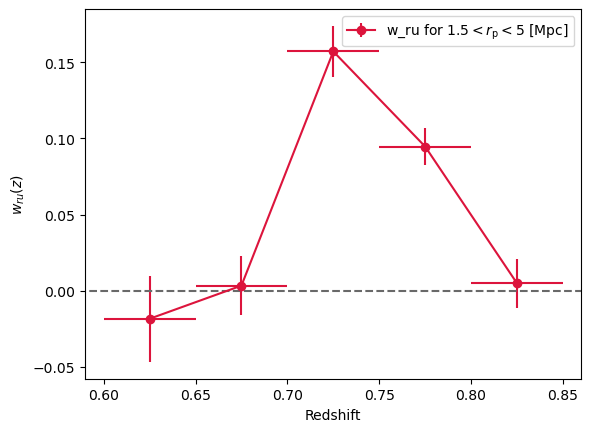

In [32]:
ialpha=1
plt.figure(dpi=100)
plt.xlabel('Redshift')
plt.ylabel(r'$w_{ru}(z)$')

Z5=np.array([0.625+0.05*i for i in range(5)]) #Z list for 8 bins


plt.errorbar(Z5, A0[:,ialpha] ,xerr=[0.025 for i in range(5)],yerr=B0[:,ialpha],color='crimson',marker='o',label=r'w_ru for $1.5<r_{\rm p}<5$ [Mpc]')
plt.plot([0.55,0.9],[0,0],linestyle='--',color='dimgrey')
plt.xlim(0.59,0.86)
plt.legend()

In [30]:
# cf A2 of the Auto-corr code
w_rr=np.array([0.2341, 0.3189,   0.2476, 0.2864, 0.2835])
w_uu=np.copy(w_rr)# As u=r for our test....

Lets get the n(z) with a M5 bias correction, and compare with the truth


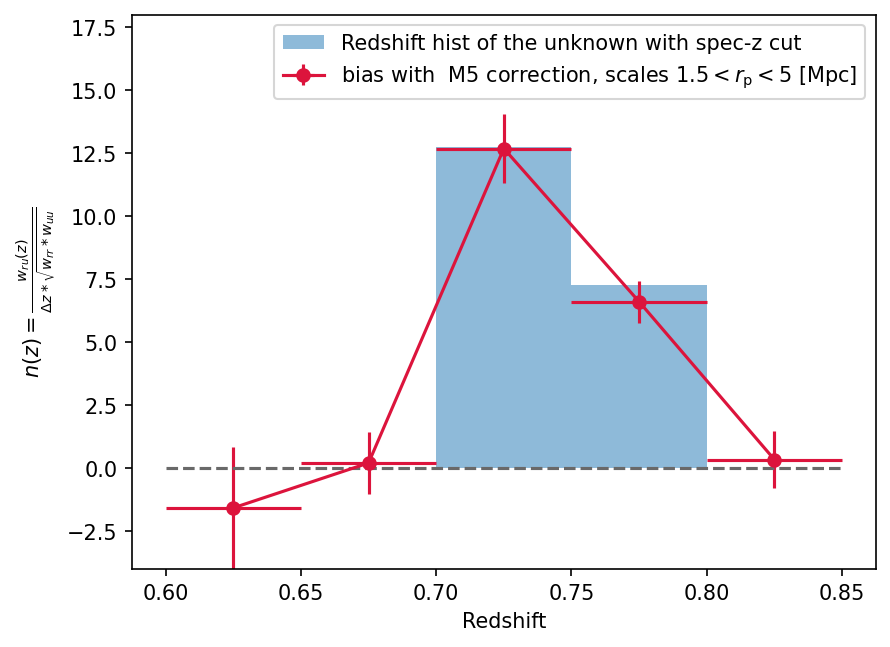

In [41]:
ialpha=1
plt.figure(dpi=150)
plt.xlabel('Redshift')
plt.ylabel(r'$n(z)=\frac{w_{ru}(z)}{\Delta z *\sqrt{w_{rr}*w_{uu}}}$' )

Z5=np.array([0.625+0.05*i for i in range(5)]) #Z list for 8 bins

plt.errorbar(Z5, [A0[i][ialpha]/np.sqrt(w_rr[i]*w_uu[i])/0.05 for i in range(5)],xerr=[0.025 for i in range(5)],yerr=[B0[i][ialpha]/np.sqrt(w_rr[i]*w_uu[i])/0.05  for i in range(5)],color='crimson',marker='o',label=r'bias with  M5 correction, scales $1.5<r_{\rm p}<5$ [Mpc]')
plt.plot([0.6,0.85],[0,0],linestyle='--',color='dimgrey')

#plt.fill_between([0.7,0.77],[-3,-3],[18,18],label='spec-z cut on the unknown sample',alpha=0.5)

sel_elg=((z_eboss_ELG_south>0.7)&(z_eboss_ELG_south<0.77))
z_unk =z_eboss_ELG_south[sel_elg]
plt.hist(z_unk,bins=Z5-0.025,density=True,alpha=0.5,label='Redshift hist of the unknown with spec-z cut')

plt.ylim(-4,18)
plt.legend()
print('Lets get the n(z) with a M5 bias correction, and compare with the truth')


In [33]:
print('norm of the n(z) measured', 0.05*np.sum([max(0,A0[i][ialpha]/np.sqrt(w_rr[i]*w_uu[i])/0.05) for i in range(5)]) )
print('as we use M5 correction, this should be close to 1')
print('all good')

norm of the n(z) measured 0.992799640205173
as we use M5 correction, this should be close to 1
all good


# This is how to compute the redshift-covariance matrix from multi_cov returned by the code....

The covariance is predicted to be diagonal, so in practice this is not very usefull...

In [35]:
Cmat=np.transpose(C0,(2,1,0))
print(np.shape(Cmat))
Nz=np.size(Cmat,2)
Nalpha=np.size(Cmat,0)
Njkk=np.size(Cmat,1)

w_wz1=1/Njkk*np.sum(Cmat,axis=1)
Cmat_centered = Cmat - w_wz1[:, None, :] 
Cov_wz1 = np.einsum("ijk,ijz->ikz", Cmat_centered , Cmat_centered ) * (Njkk - 1) / Njkk
Err_wz1=np.diagonal(Cov_wz1,axis1=1,axis2=2)**0.5

print(np.shape(w_wz1),np.shape(Err_wz1),np.shape(Cov_wz1))

(3, 100, 5)
(3, 5) (3, 5) (3, 5, 5)


In [36]:
#first dim in Nalpha, then Nz
print(np.shape(w_wz1))
print(np.shape(Cov_wz1))

(3, 5)
(3, 5, 5)


These two should match


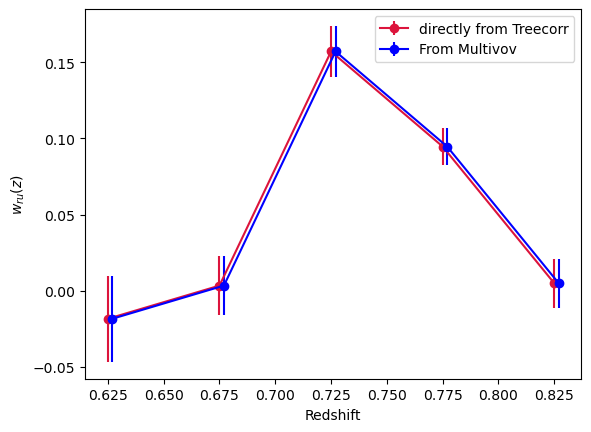

In [37]:
ialpha=1
plt.xlabel('Redshift')
plt.ylabel(r'$w_{ru}(z)$')

Z5=np.array([0.625+0.05*i for i in range(5)]) #Z list for 8 bins


plt.errorbar(Z5, [A0[i][ialpha] for i in range(5)],yerr=[B0[i][ialpha] for i in range(5)],color='crimson',marker='o',label=r'directly from Treecorr')
plt.errorbar(Z5+0.002, w_wz1[ialpha],yerr=Err_wz1[ialpha],color='blue',marker='o',label=r'From Multivov')

plt.legend()
print('These two should match')

Let's check if our (noisy) jkk covariance is diagonal

Text(0.5, 1.0, 'Covariance')

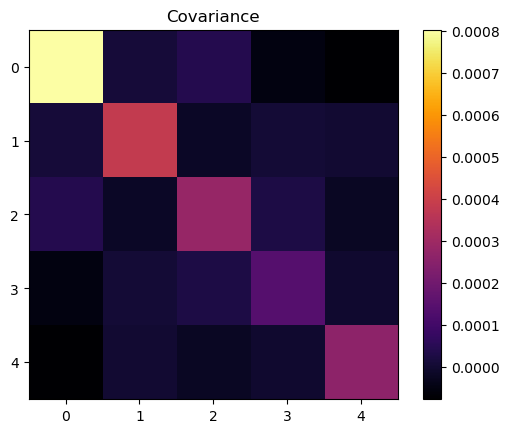

In [38]:
plt.imshow(Cov_wz1[ialpha],cmap='inferno')
plt.colorbar()
plt.title('Covariance')

Yes it is...


Text(0.5, 1.0, 'Reduced covariance $c_{ij}/\\sqrt{c_{ii}c_{jj}}$')

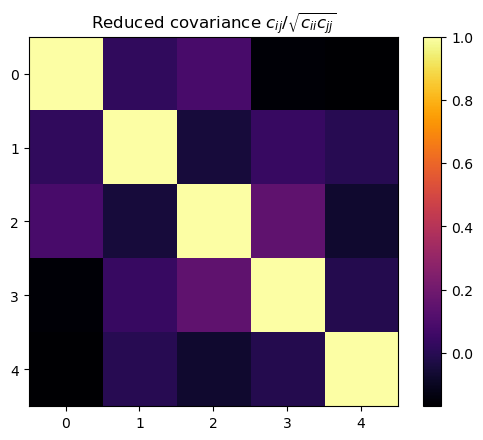

In [39]:
print('Yes it is...')
plt.imshow([[Cov_wz1[ialpha][i][j]/np.sqrt(Cov_wz1[ialpha][i,i]*Cov_wz1[ialpha][j][j]) for i in range(5)] for j in range(5)],cmap='inferno')
plt.colorbar()
plt.title(r'Reduced covariance $c_{ij}/\sqrt{c_{ii}c_{jj}}$')